# Pine & 8th St. Bioretention Notebook
This file was used for generating figures etc for the manuscript on 6PPD-quinone fate through the Pine and 8th st. bioretention cell


In [1]:
#Load packages

import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set_style('ticks')
import matplotlib.pyplot as plt
#This is the name of the python module containing the Bioretention Blues submodel.
from BioretentionBlues import BCBlues

D:\GitHub\SubsurfaceSinks\FugModel.py:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if calctype is 'fss': #Peform forward steady-state calcs
D:\GitHub\SubsurfaceSinks\FugModel.py:73: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif calctype is 'bss': #Perform backward calcs with lair concentration as target and emissions location


In [2]:
#Import the res file, load the others
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
#locsumm = pd.read_excel('inputfiles/QuebecSt_TreeTrench.xlsx',index_col = 0)
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_wateryear.xlsx')
#chemsumm = pd.read_excel('inputfiles/Kortright_ALL_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
pp = None
#inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/'
inpath = 'C:/Users/trodge01/Documents/BigPickles/'
#res = pd.read_pickle(inpath+'outputspiketest1.pkl')
#res = pd.read_pickle(inpath+'wateryear_fvalve_Foc_Asys_Hp.pkl')
res = pd.read_pickle(inpath+'wateryear_.pkl')
#res = pd.read_pickle(inpath+'20230112_SpikeTestCalibrated.pkl')
#res = pd.read_pickle(fpath+'/pickles/outputtest.pkl')
res.head()

x        dx  time    dm  maskts  maskss  porositywater  \
6PPDQ 240 0  0.012778  0.025556   0.0  True   False    True           0.42   
          1  0.038333  0.025556   0.0  True   False    True           0.42   
          2  0.063889  0.025556   0.0  True   False    True           0.42   
          3  0.089444  0.025556   0.0  True   False    True           0.42   
          4  0.115000  0.025556   0.0  True   False    True           0.42   

               Awater  Vsubsoil        V2  ...  a6_t1  M6_t1  a7_t1  M7_t1  \
6PPDQ 240 0  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
          1  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
          2  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
          3  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
          4  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   

             a8_t1  M8_t1  Mqin  Min_p  M_xf  M_n  
6PPDQ 240 0    0.0    0.0   0.0    0.0   0.0  0.0  
          1    0.0    0.0   NaN    NaN   0.0  0.0  
          2    0.0    0.0   NaN    NaN   0.0  0.0  
          3    0.0    0.0   NaN    NaN   0.0  0.0  
          4    0.0    0.0   NaN    NaN   0.0  0.0  

[5 rows x 473 columns]

In [6]:
#Calculate the masses
#timeseries = pd.read_excel('inputfiles/2014_timeseries.xlsx')
bc = BCBlues(locsumm,chemsumm,params,timeseries,numc)
#timeseries = timeseries.loc[timeseries.time<240,:]
indfactor = 1#3#3#'Load' #3#3
if indfactor == 'Load':
    timeseries = pd.read_pickle(pklpath+timedfname)
else:
    try: 
        int(indfactor) == indfactor
        timeseries = bc.modify_timestep(timeseries,indfactor)
    except TypeError:
        pass
#timeseries = timeseries[timeseries.time<=6]
bc = BCBlues(locsumm,chemsumm,params,timeseries,numc)
mbal = bc.mass_balance(res,numc)
mbal_cum = bc.mass_balance_cumulative(numc, mass_balance = mbal,normalized=True)
mbal_cum.head()
mass_flux = bc.mass_flux(res,numc) 

In [7]:
#Calculate the MEC
#mass_flux = bc.mass_flux(res,numc) 
numx = len(res.index.levels[2])-1
Q_stormsewer = np.array(res.loc[(slice(None),slice(None),numx-1),'Qout'])\
    + np.array(res.loc[(slice(None),slice(None),numx),'advpond'])
pct_Qover = np.array(res.loc[(slice(None),slice(None),numx),'advpond'].sum())\
                                      /np.array(res.loc[(slice(None),slice(None),numx),'Qin'].sum())
#Mean Effluent Concentration (ng/L)
#res.loc[:,'MEC_ngl'] = 1e6*((mass_flux.loc[:,['N_effluent','Nadvpond']].sum(axis=1).groupby(level=[0,1]).sum())\
#                                /np.array(Q_stormsewer)).groupby(level=0).mean()*chemsumm.loc[:,'MolMass']
MEC = 1e6*((mass_flux.loc[:,['N_effluent','Nadvpond']].sum(axis=1).groupby(level=[0]).sum())\
                                    /np.array(Q_stormsewer.sum()))*chemsumm.loc[:,'MolMass']
MEC

6PPDQ        154.056277
Bromide       64.553226
Rhodamine    477.784620
dtype: float64

In [ ]:
#Plot the hydrology
hydro_name = 'flowtest.pkl'
flow_time = pd.read_pickle(inpath + hydro_name)
Qmeas = timeseries.loc[timeseries.time>=0,['time','Qout_meas']]
ylabel = 'Flow Rate (m³/h)'
xlabel = 'Time'
fig,ax = plt.subplots(1,2,figsize=(14,8),dpi=300,sharey=True)
#First event
comp = 'drain'
mask1 = (flow_time.time>=0) & (flow_time.time<6)
ax[0].plot(flow_time.loc[(mask1.copy(),comp),'time'],flow_time.loc[(mask1.copy(),comp),'Q_todrain'])
#startind = len(Qmeas)- len(flow_time.loc[(mask1,'drain'),'time'])
ax[0].plot(flow_time.loc[(mask1,'drain'),'time'],Qmeas.loc[Qmeas.time<6,'Qout_meas'],'k') 
ax[0].plot(flow_time.loc[(mask1.copy(),comp),'time'],flow_time.loc[(mask1.copy(),'pond'),'Q_in'],'#808080')
#Second Event
comp = 'drain'
mask2 = (flow_time.time>=143)
ax[1].plot(flow_time.loc[(mask2.copy(),comp),'time'],flow_time.loc[(mask2.copy(),comp),'Q_todrain'])
#startind = len(Qmeas)- len(flow_time.loc[(mask1,'drain'),'time'])
ax[1].plot(flow_time.loc[(mask2,'drain'),'time'],Qmeas.loc[Qmeas.time>=143,'Qout_meas'],'k') 
ax[1].plot(flow_time.loc[(mask2.copy(),comp),'time'],flow_time.loc[(mask2.copy(),'pond'),'Q_in'],'#808080')
ax[0].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)
ax[0].set_ylim([0,10])
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
#fig.savefig(fpath+'HydroFig.pdf', format='pdf',bbox_inches= 'tight')   

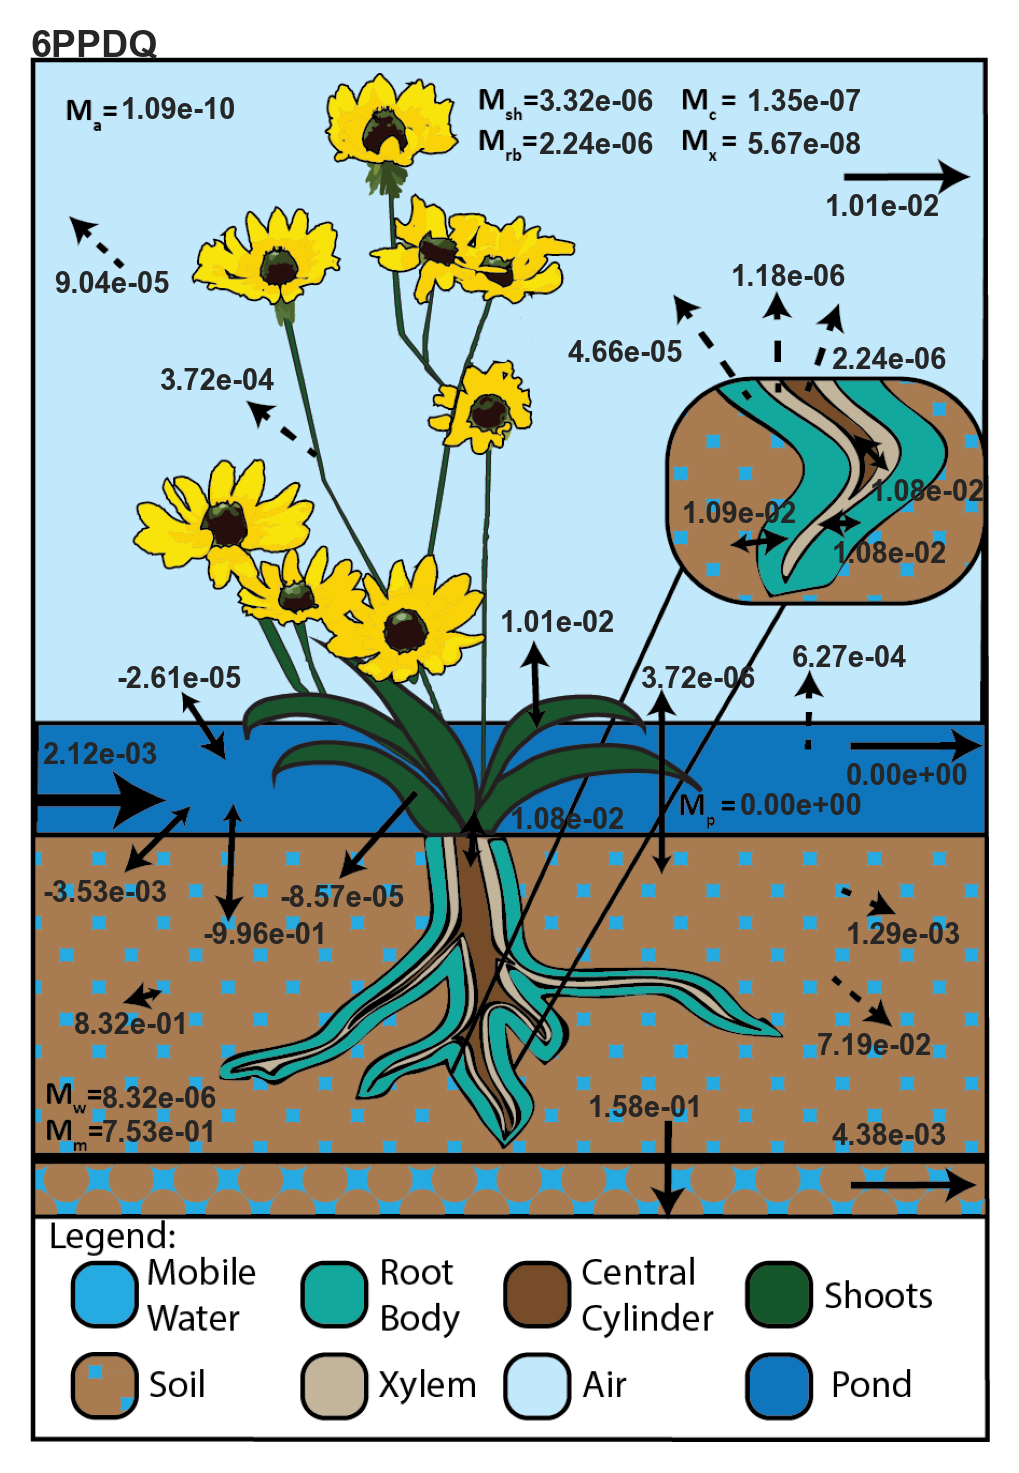

In [9]:
#Plot the fate diagram. Choose the compound and the time to display (in hours).
compound = '6PPDQ'#'Bromide'#use same name as in chemsumm
#Set time (hrs), any time after end gives the end.
time = 10000#6#1000#6#1000
fig,ax = bc.BC_fig(numc,mass_balance=mbal_cum,time = time,compound=compound,figheight=6,fontsize=7,dpi=300)
#Save the figure if you like. I save in pdf then edit in illustrator.
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
#fig.savefig(fpath+'OutputModelFig_wateryear_fvalve_Foc_Kinf_Hp.pdf', format='pdf',bbox_inches= 'tight')  
fig.savefig(fpath+'OutputModelFig_basewateryear.pdf', format='pdf',bbox_inches= 'tight')  

In [14]:
Couts = bc.conc_out(numc,timeseries,chemsumm,res)
Couts.loc[:,'6PPDQ_Coutest'] = Couts.loc[:,'6PPDQ_Coutest'] *1e6 #ng/L
Couts.head()
measdat = pd.read_excel('Tracer_test_measurements.xlsx')
Couts.head()

,time,Qout_meas,Qout,6PPDQ_Coutmeas,6PPDQ_Coutest,Bromide_Coutmeas,Bromide_Coutest,Rhodamine_Coutmeas,Rhodamine_Coutest
244,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,0.005556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,0.011111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,0.016667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


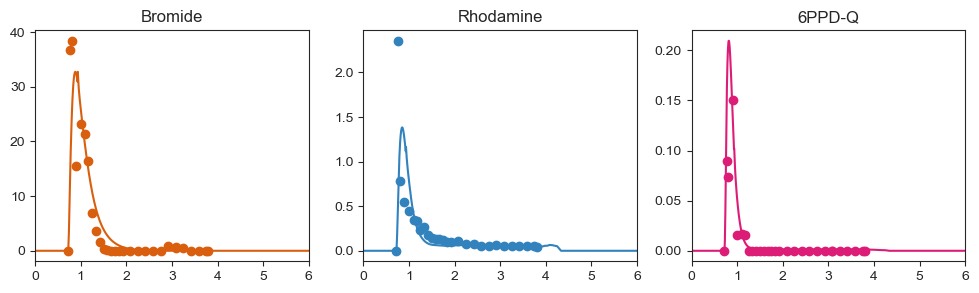

In [20]:
#Model Performance Plots
measdat = pd.read_excel('Tracer_test_measurements.xlsx')
fig,axs = plt.subplots(1,3,figsize=(12,3),sharex='all')
#Plot 1 - Bromide, Benzotriazole, Rhodamine (mg/L)
axs[0].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['Bromide_meas (mg/L)']],color='#d95f0e') #fec44f #d95f0e
#axs[0,0].scatter(measdat.loc[:,'Time(hrs)']
#                            ,measdat.loc[:,['Benzotriazole_meas(mg/L)']],color='#756bb1') #bcbddc, #756bb1
axs[1].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['Rhodamine_meas (mg/L)']],color='#3182bd')#9ecae1, #3182bd
#Line Plots
axs[0].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['Bromide_Coutest']],color='#d95f0e')#fec44f #d95f0e
#axs[0,0].plot(Couts.loc[:,'time']
#                            ,Couts.loc[:,['Benzotriazole_Coutest']],color='#756bb1')#bcbddc, #756bb1
axs[1].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['Rhodamine_Coutest']],color='#3182bd')#9ecae1, #3182bd
#Plot 2 - 6PPDQ (ng/L)
axs[2].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['6PPDQ_meas (ng/L)']],color='#dd1c77') #dd1c77 #c994c7
#Line Plots
axs[2].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['6PPDQ_Coutest']],color='#dd1c77')#dd1c77 #c994c7
axs[0].set_xlim((0,6))
axs[0].set_title('Bromide')
axs[1].set_title('Rhodamine')
axs[2].set_title('6PPD-Q')
#axs[0,0].set(xlim=(0, 7.2))
#axs[0,0].set(ylim=(0, 95))
#axs[0,1].set(ylim=(0, 395))
#axs[1,0].set(ylim=(0, 9.5))
fpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
fig.savefig(fpath+'testvsest_20230112.pdf', format='pdf',bbox_inches= 'tight')  

In [16]:
from hydroeval import kge #Kling-Gupta efficiency (Kling-Gupta et al., 2009)
import hydroeval
Couts2 = bc.conc_out(numc,timeseries,chemsumm,res)
KGE = {}
for ind,chem in enumerate(chemsumm.index):
    try:
        KGE[chem] = (hydroeval.evaluator(kge, np.array(Couts2.loc[:,chem+'_Coutest']),\
                          np.array(Couts2.loc[:,chem+'_Coutmeas'])))
    except KeyError:
        pass
KGE

{'6PPDQ': array([[0.11111702],
        [0.92683556],
        [1.48656729],
        [1.74027845]]),
 'Bromide': array([[0.83557735],
        [0.90648603],
        [1.03120514],
        [1.13159098]]),
 'Rhodamine': array([[0.71261024],
        [0.74228317],
        [1.12098759],
        [1.03920348]])}

In [ ]:
mass_flux = bc.mass_flux(res,numc)
recovery = mass_flux.N_effluent.groupby(level=0).sum()/mass_flux.N_influent.groupby(level=0).sum()
recovery

In [207]:
#full_series = pd.read_excel('inputfiles/wateryear_timeseries.xlsx')
#SWMMseries.head()
timeseries = pd.DataFrame(columns = ['dt','elapsedtime','precip','runoff'])
ind = 0
#pdb.set_trace()
timeseries.loc[ind,:] = 0.
SWMMseries = full_series#[:5000]
p_shift = 10*60 #Start changing timestep X hrs before precipitation
r_shift = 1*60 #Start changing timestep X hrs after Qin ends
SWMMseries.loc[:,'p_shift'] = SWMMseries.Precip.shift(-15*60)#Start changing X hrs before precipitation
#Chose 15 hrs to give 6,3,2,1,0.5,0.5,0.25,0.25,0.25,0.25,10/60,10/60,10/60,10/60,5/60,5/60,5/60,5/60,1/60
#SWMMseries.loc[:,'r_shift'] = SWMMseries.Runoff.shift(-1*60)#Start changing X hrs after Qin ends
pswitch = False #To ramp up
rswitch = True #To ramp down. Start true.
ramp = np.array([6.0,3.0,2.0,1.0,0.5,0.25,10/60,5/60,1/60])
rampstep = 3
dt = 3.0 #Hours. Baseline is 6 hours in dry periods, 1 minute in wet periods
t = 0
while t < len(SWMMseries.index):
    #pdb.set_trace()
    if pswitch == True: #Ramp timestep down to 1 minute and stay there until rswitch activates
        rampstep = rampstep + 1
        if rampstep >= len(ramp):#stay at 1/60 if there
            rampstep = len(ramp)-1       
        #Start to ramp up to 6 hrs if the next X minutes all have zero flow & Y mins have 0 precipitation 
        if  (rswitch == False) & (SWMMseries.loc[t:t+r_shift,'Runoff'].sum() == 0)& (SWMMseries.loc[t:t+p_shift,'Precip'].sum() == 0):
            rswitch = True
            pswitch = False
            
    elif rswitch == True:
        rampstep = rampstep - 1
        if rampstep < 0:#stay at 6 hrs if there
            rampstep = 0 
        #Start to ramp down to 1 minute when precipitation appears
        if (pswitch == False) & (SWMMseries.loc[t:t+p_shift,'Precip'].sum() != 0):
            pswitch = True
            rswitch = False
            #rampstep = 0
    #Now, we are going to make the timeseries for the BC Blues model 
    #Each timestep represents the average from t to t + dt (not including the last step)
    #Elapsed time at the beginning of the timestep (hrs)
    #timeseries.loc[ind,'elapsedtime'] += dt
    #Then, change dt
    dt = ramp[rampstep]
    timeseries.loc[ind+1,'elapsedtime'] = timeseries.loc[ind,'elapsedtime']+dt
    #Next, add the accumulated precipitation and runoff across the timestep
    SWMMend = int(dt *60)-1 #Averaging period
    timeseries.loc[ind,'dt'] = dt
    timeseries.loc[ind,'precip'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])*1/60/dt #mm/hr
    timeseries.loc[ind,'runoff'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Runoff'])*1/60/dt*3.6 #m³/h
    while (dt > ramp[-1]) & (timeseries.loc[ind,'runoff'] > 0):
        rampstep = rampstep +1
        dt = ramp[rampstep]
        timeseries.loc[ind+1,'elapsedtime'] = timeseries.loc[ind,'elapsedtime']+dt
        #Next, add the accumulated precipitation and runoff across the timestep
        SWMMend = int(dt *60)-1 #Averaging period
        timeseries.loc[ind,'dt'] = dt
        timeseries.loc[ind,'precip'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])*1/60/dt #mm/hr
        timeseries.loc[ind,'runoff'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Runoff'])*1/60/dt*3.6 #m³/h    
    #To finish, we will go to the next t based on dt
    t += int(dt*60)
    ind += 1
    #Ramp up to 1 minute from 6 hours when pswitch triggers
#timeseries.loc[0,'dt'] = 6
timeseries = timeseries.drop(index=max(timeseries.index))
#timeseries[:25]
#timeseries.to_excel('inputfiles/swmmouts_2014.xlsx')
timeseries.to_excel('inputfiles/swmmouts_wateryear.xlsx')

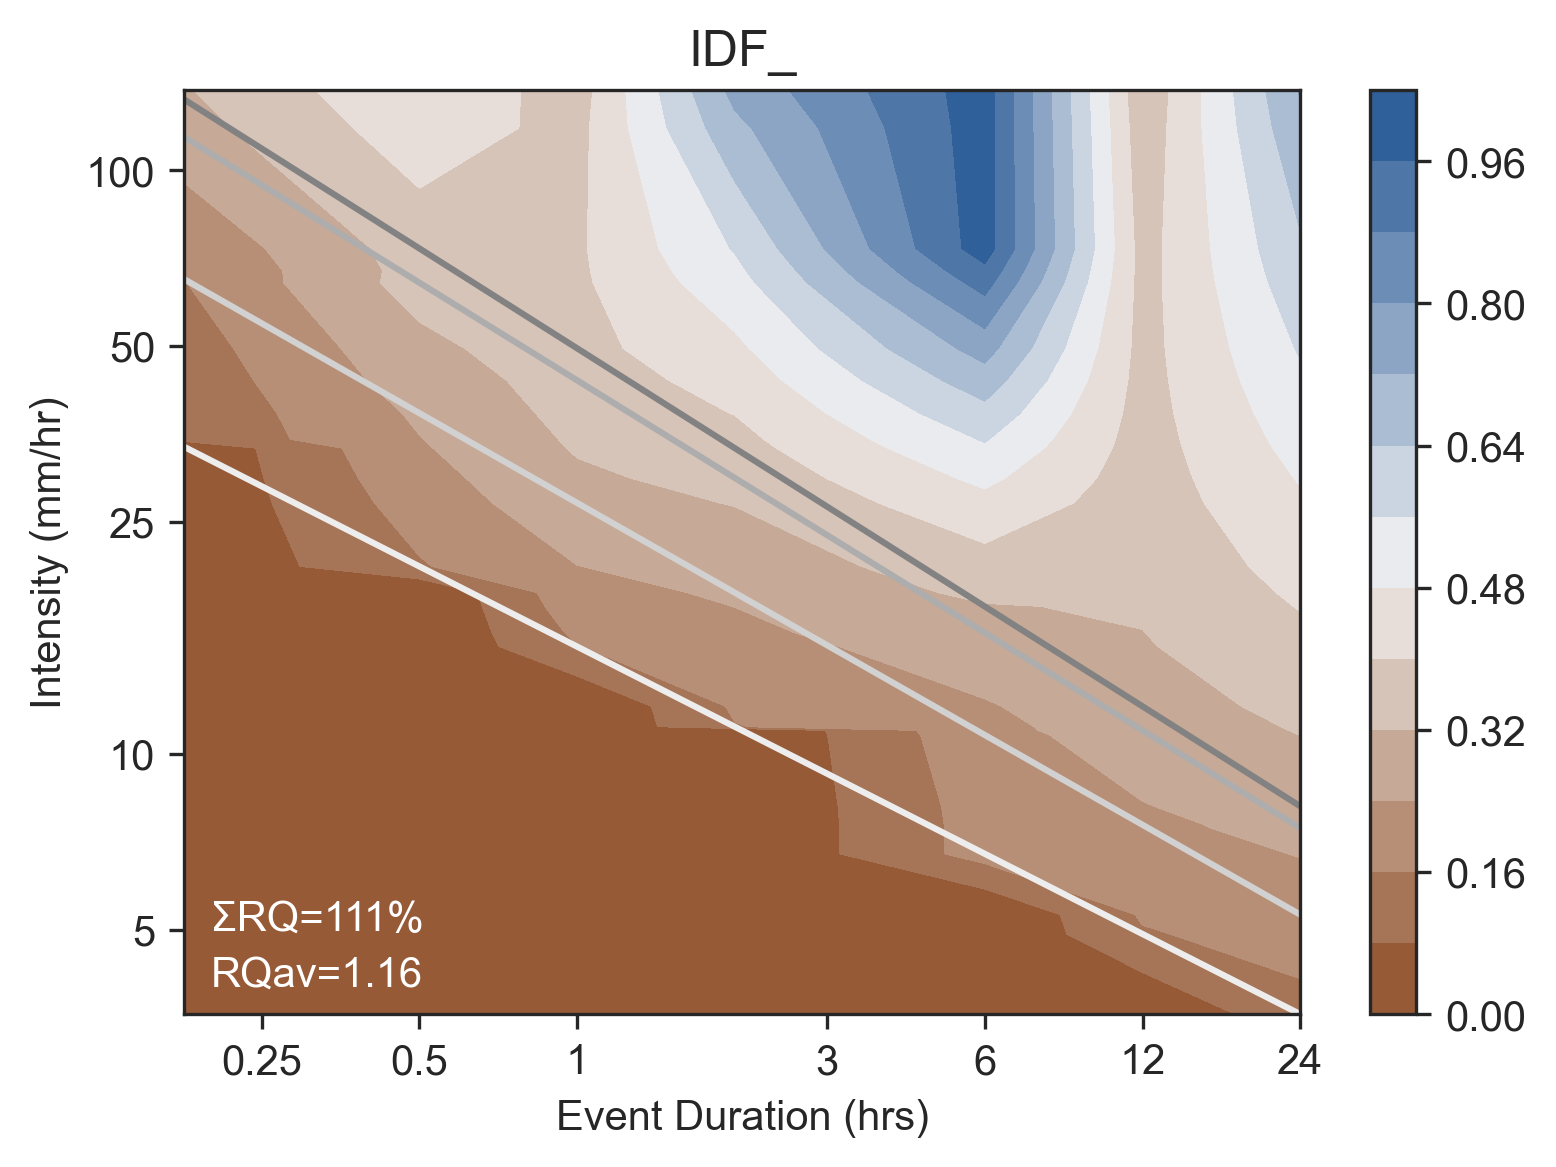

In [143]:
#Plot system performance on IDF curves. This plots the actual values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
#defname = ['IDF_defaults.pkl']
defname = 'IDF_.pkl'
defdata = pd.read_pickle(inpath+defname)

#scenarios = ['defaults','fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False}
combos = ((0,0,0,0,0,0,0),)#,(0,0,0,1,0,0),(1,1,0,0,1,0),(1,1,0,0,0,0),(0,1,0,1,0,0))
#combos = list(itertools.product([0,1],repeat=6))
#for scenario in scenarios:
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    #Change this to match the actual name
    testname = 'IDF_lowkn'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    pltdata = pd.read_pickle(inpath+testname)
    #Define the x and y axes
    xticks = [0.25,0.5,1,3, 6,12,24]
    xticks = [np.log10(xticks),xticks]
    yticks = [5,10,25,50,100]
    yticks = [np.log10(yticks),yticks]
    #Define the variables to plot
    pltvars=['pct_advected','LogD','LogI']
    #pltvars=['RQ_av','LogD','LogI']
    #Determine the average risk quotients, sum as a % of the base-case, av as actual value
    bcRQsum = defdata.RQ_sum.sum()
    RQs = [pltdata.RQ_sum.sum()/bcRQsum,pltdata.RQ_av.mean()]
    #Define other parameters
    #Limit of interpolation - values outside of these limits will be set to these. Use "none" for no limits
    interplims = [0.,1.]
    #interplims = [0.,3.5]
    vlims = [0.0,1.0]#[0.15,3.5]#
    #pdb.set_trace()
    #define the colormap - default is brown-blue
    cmap = None
    #cmap = sns.cubehelix_palette(start=.75, rot=-.5,light=0.85, as_cmap=True)
    #cmap = sns.cubehelix_palette(n_colors = 7,start=1.40, rot=-0.9,gamma = 0.3, hue = 0.9, dark=0.1, light=.95,as_cmap=True,reverse=True)
    bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) 
    fig,ax = bc.plot_idfs(pltdata,pltvars=pltvars,cmap=cmap,vlims=vlims,interplims=interplims,
                          xticks=xticks,yticks=yticks,figsize=(6,4))
    ax.set_xlabel('Event Duration (hrs)')
    ax.set_ylabel('Intensity (mm/hr)')
    #figname = 'IDF_'+str(scenario)
    figname = 'IDF_'+'_'.join(filtered)
    ax.set_title(figname)
    #Annotate the risk quotients
    ax.annotate('ΣRQ='+f'{RQs[0]:.0%}',xy= (np.log10(0.2),np.log10(5)),color = 'w')
    ax.annotate('RQav='+f'{RQs[1]:.2f}',xy= (np.log10(0.2),np.log10(4)),color = 'w')           
    figpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
    #
    fig.savefig(figpath+figname+'.pdf',format='pdf')
    #fig.savefig()

In [140]:
defdata.RQ_sum.sum()

28437.433130084883

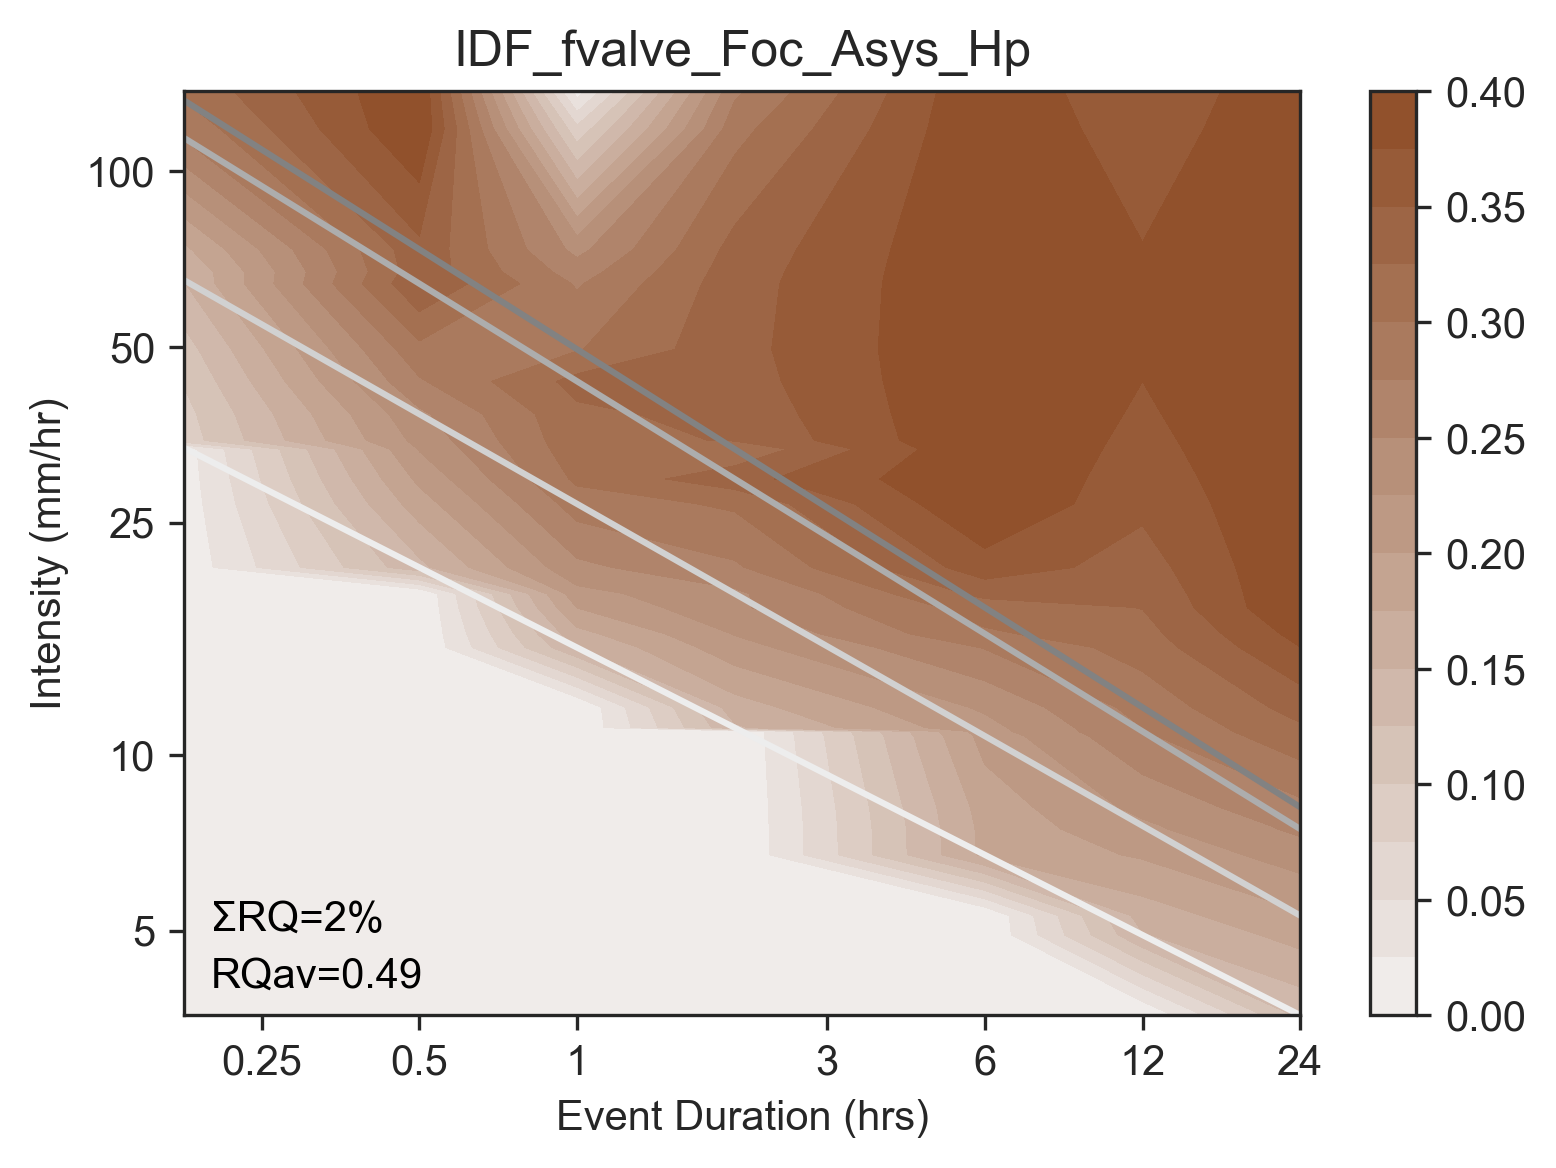

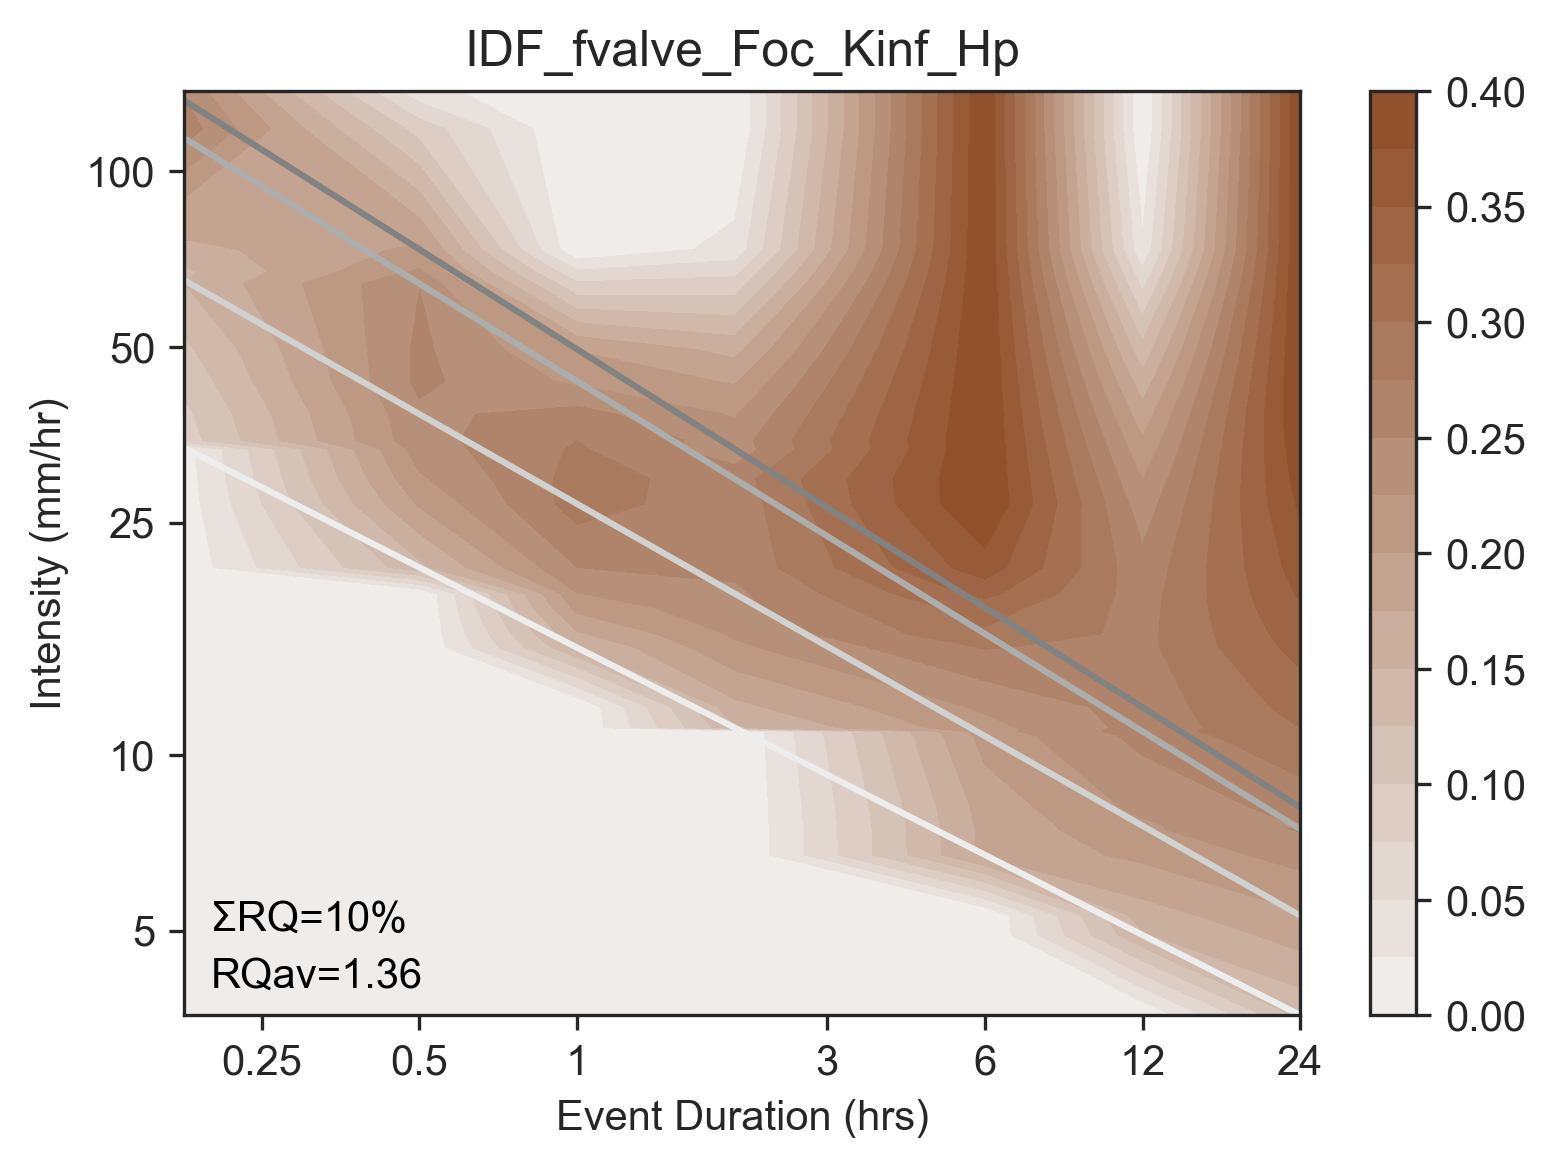

In [190]:
import os
import itertools
import pdb
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_lowkn.pkl'
#defname = 'IDF_.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False,'hpipe':False}#
#combos = ((1,0,0,0,0,0,0),(0,1,0,0,0,0,0),(0,0,1,0,0,0,0),(0,0,0,1,0,0,0),(0,0,0,0,1,0,0),(0,0,0,0,0,1,0),(0,0,0,0,0,0,1))
#combos = ((1,1,0,0,1,1,0),)#(0,1,0,0,0,0),(0,0,1,0,0,0),(0,0,0,1,0,0),(0,0,0,0,1,0),(0,0,0,0,0,1),
#          (1,1,0,0,1,1),(1,1,0,0,0,1))
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]
#combos = ((0,0,0,0,0,0,1),(0,0,1,0,0,0,0))
#combos =((1,1,0,1,1,1,0),)
combos = ((1,1,0,0,1,1,0),(1,1,1,0,0,1,0)) #new build ((1,1,1,0,0,1,0),)#retrofit 
for combo in combos:
    #pdb.set_trace()
    scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False,'hpipe':False}
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    #testname = 'IDF_lowkn'+'_'.join(filtered)+'.pkl'
    testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    #Define the x and y axes
    xticks = [0.25,0.5,1,3, 6,12,24]
    xticks = [np.log10(xticks),xticks]
    yticks = [5,10,25,50,100]
    yticks = [np.log10(yticks),yticks]
    #Define the variables to plot
    pltvars=['pct_stormsewer','LogD','LogI']
    pltvars_delta = pltvars.copy()
    delname = pltvars[0] +'_delta'
    pltvars_delta[0] = delname
    pltdata.loc[:,delname] = defdata.loc[:,pltvars[0]] - pltdata.loc[:,pltvars[0]]
    #pdb.set_trace()
    #pltvars=['RQ_av','LogD','LogI']
    #Determine the average risk quotients, sum as a % of the base-case, av as actual value
    bcRQsum = defdata.RQ_sum.sum()
    RQs = [pltdata.RQ_sum.sum()/bcRQsum,pltdata.RQ_av.mean()]
    #Define other parameters
    #Limit of interpolation - values outside of these limits will be set to these. Use "none" for no limits
    hilim = 0.4#np.round(max(pltdata.loc[:,delname]),decimals=2)
    lolim = 0.0#np.round(min(pltdata.loc[:,delname]),decimals=2)
    interplims = [lolim,hilim]
    #interplims = [0.,3.5]
    vlims = [-0.4,0.4]
    #vlims = [lolim,hilim]#[0.15,3.5]#
    #pdb.set_trace()
    #define the colormap - default is brown-blue
    #cmap = None
    #if lolim<0:
    #    cmap = sns.diverging_palette(250, 30, l=40,s=80,center="light", as_cmap=True)
    #else: 
    #    cmap = sns.light_palette('#8f4e27', as_cmap=True)
    cmap = sns.diverging_palette(250, 30, l=40,s=80,center="light", as_cmap=True)
        #cmap = sns.light_palette("seagreen", as_cmap=True)
    #cmap = sns.cubehelix_palette(start=.75, rot=-.5,light=0.85, as_cmap=True)
    #cmap = sns.cubehelix_palette(n_colors = 7,start=1.40, rot=-0.9,gamma = 0.3, hue = 0.9, dark=0.1, light=.95,as_cmap=True,reverse=True)
    bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) 
    fig,ax = bc.plot_idfs(pltdata,pltvars=pltvars_delta,cmap=cmap,vlims=vlims,interplims=interplims,
                          xticks=xticks,yticks=yticks,figsize=(6,4))
    ax.set_xlabel('Event Duration (hrs)')
    ax.set_ylabel('Intensity (mm/hr)')
    #figname = 'IDF_delta_'+str(scenario)
    figname = 'IDF_'+'_'.join(filtered)
    ax.set_title(figname)
    #Annotate the risk quotients
    ax.annotate('ΣRQ='+f'{RQs[0]:.0%}',xy= (np.log10(0.2),np.log10(5)),color = 'k')
    ax.annotate('RQav='+f'{RQs[1]:.2f}',xy= (np.log10(0.2),np.log10(4)),color = 'k')           
    figpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
    #
    fig.savefig(figpath+figname+'.pdf',format='pdf')
    #fig.savefig()

In [183]:
#Find best scenarios
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False, 'hpipe':False}
#combos = ((0,0,0,1,0,0),)#((0,0,0,1,0,0),(0,1,0,0,0,0),(0,1,0,1,0,0))
#combos = ((0,0,0,0,0,0,0),(1,0,0,0,0,0,0),(0,1,0,0,0,0,0),(0,0,1,0,0,0,0),(0,0,0,1,0,0,0),(0,0,0,0,1,0,0),
#          (0,0,0,0,0,1,0),(0,0,0,0,0,0,1))
#n
combos = ((1,1,0,0,1,1,0),) #new build ((1,1,1,0,0,1,0),)#retrofit 
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]
scenario_list = pd.DataFrame(columns=['RQ_sum','RQ_av'])
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    bcRQsum = defdata.RQ_sum.sum()
    scenario_list.loc[testname[4:-4],'RQ_sum'] = pltdata.RQ_sum.sum()/bcRQsum
    scenario_list.loc[testname[4:-4],'RQ_av'] =pltdata.RQ_av.mean()
    scenario_list.loc[testname[4:-4],'pct_Qover'] =pltdata.pct_Qover.mean()
    scenario_list.loc[testname[4:-4],'pct_advected'] =pltdata.pct_advected.mean()
scenario_list.sort_values('RQ_sum',ascending=True)[0:25]


,RQ_sum,RQ_av,pct_Qover,pct_advected
fvalve_Foc_Asys_Hp,0.021113,0.493881,0.005834,0.035142


In [163]:
#Find best scenarios - retrofit.
#Retrofit-possible scenarios are: fvalve, Foc, Kinf?, Hp
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False, 'hpipe':False}
#combos = ((0,0,0,1,0,0),)#((0,0,0,1,0,0),(0,1,0,0,0,0),(0,1,0,1,0,0))
#for scenario in scenarios:
combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]

scenario_list = pd.DataFrame(columns=['RQ_sum','RQ_av'])
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    #Skip these ones
    if  (scenario_dict['Dsys'] == True) | (scenario_dict['Asys'] == True)| (scenario_dict['hpipe'] == True):
        continue
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    bcRQsum = defdata.RQ_sum.sum()
    scenario_list.loc[testname[4:-4],'RQ_sum'] = pltdata.RQ_sum.sum()/bcRQsum
    scenario_list.loc[testname[4:-4],'RQ_av'] =pltdata.RQ_av.mean()
    scenario_list.loc[testname[4:-4],'pct_Qover'] =pltdata.pct_Qover.mean()
    scenario_list.loc[testname[4:-4],'pct_advected'] =pltdata.pct_advected.mean()
scenario_list.sort_values('RQ_sum',ascending=True)[0:25]


,RQ_sum,RQ_av,pct_Qover,pct_advected
fvalve_Foc_Kinf_Hp,0.105519,1.359851,0.030446,0.089909
fvalve_Kinf_Hp,0.105519,1.359851,0.030446,0.252190
fvalve_Foc_Kinf,0.22928,2.091463,0.065025,0.115472
fvalve_Kinf,0.22928,2.091464,0.065025,0.259747
Foc_Kinf_Hp,0.232218,0.478076,0.030446,0.097976
Foc_Kinf,0.258114,0.696361,0.065025,0.122282
Foc_Hp,0.393389,0.811072,0.081643,0.113876
Foc,0.527671,1.304001,0.135527,0.158249
fvalve_Foc_Hp,0.547295,2.228071,0.081643,0.111940
fvalve_Hp,0.547295,2.228071,0.081643,0.224505


In [ ]:
defdata
#len(combos)

In [ ]:
pltdata

In [175]:
#Find best scenarios - low exfiltration
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_lowkn.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False, 'hpipe':False}
#combos = ((0,0,0,1,0,0),)#((0,0,0,1,0,0),(0,1,0,0,0,0),(0,1,0,1,0,0))
combos = ((0,0,0,0,0,0,0),(1,0,0,0,0,0,0),(0,1,0,0,0,0,0),(0,0,1,0,0,0,0),(0,0,0,1,0,0,0),(0,0,0,0,1,0,0),
          (0,0,0,0,0,1,0),(0,0,0,0,0,0,1))
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]
scenario_list = pd.DataFrame(columns=['RQ_sum','RQ_av'])
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    #testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    testname = 'IDF_lowkn'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    bcRQsum = defdata.RQ_sum.sum()
    scenario_list.loc[testname[4:-4],'RQ_sum'] = pltdata.RQ_sum.sum()/bcRQsum
    scenario_list.loc[testname[4:-4],'RQ_av'] =pltdata.RQ_av.mean()
    scenario_list.loc[testname[4:-4],'pct_Qover'] =pltdata.pct_Qover.mean()
    scenario_list.loc[testname[4:-4],'pct_advected'] =pltdata.pct_advected.mean()
scenario_list.sort_values('RQ_sum',ascending=True)[0:25]


,RQ_sum,RQ_av,pct_Qover,pct_advected
lowknFoc,0.387104,0.763618,0.135527,0.157829
lowknAsys,0.530029,0.672169,0.040061,0.163973
lowknDsys,0.690216,0.949948,0.135527,0.198687
lowknfvalve,0.776211,2.683989,0.135527,0.159728
lowknKinf,0.885115,1.095677,0.065025,0.269777
lowknHp,0.983721,0.950152,0.081643,0.227285
lowkn,1.0,1.15527,0.135527,0.252706
lowknhpipe,1.010981,1.135689,0.135527,0.243747


In [179]:
#Find best scenarios - retrofit.
#Retrofit-possible scenarios are: fvalve, Foc, Kinf?, Hp
import os
import itertools
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
#defname = 'IDF_.pkl'
defname = 'IDF_lowkn.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False, 'hpipe':False}
#combos = ((0,0,0,1,0,0),)#((0,0,0,1,0,0),(0,1,0,0,0,0),(0,1,0,1,0,0))
#for scenario in scenarios:
combos = list(itertools.product([0,1],repeat=7))
#combos = combos = ((1,1,0,0,1,1,0),)
#combos = ((1,0,0,0,0,0,0),(0,1,0,0,0,0,0),(0,0,1,0,0,0,0),(0,0,0,1,0,0,0),(0,0,0,0,1,0,0),
#          (0,0,0,0,0,1,0),(0,0,0,0,0,0,1),(1,1,0,1,1,1,0),(1,1,1,0,0,1,0))
scenario_list = pd.DataFrame(columns=['RQ_sum','RQ_av'])
for combo in combos:
    #pdb.set_trace()
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_lowkn'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    #Skip these ones
    if  (scenario_dict['Dsys'] == True) | (scenario_dict['Asys'] == True)| (scenario_dict['hpipe'] == True):
        continue
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    bcRQsum = defdata.RQ_sum.sum()
    scenario_list.loc[testname[4:-4],'RQ_sum'] = pltdata.RQ_sum.sum()/bcRQsum
    scenario_list.loc[testname[4:-4],'RQ_av'] =pltdata.RQ_av.mean()
    scenario_list.loc[testname[4:-4],'pct_Qover'] =pltdata.pct_Qover.mean()
    scenario_list.loc[testname[4:-4],'pct_advected'] =pltdata.pct_advected.mean()
scenario_list.sort_values('RQ_sum',ascending=True)[0:25]


,RQ_sum,RQ_av


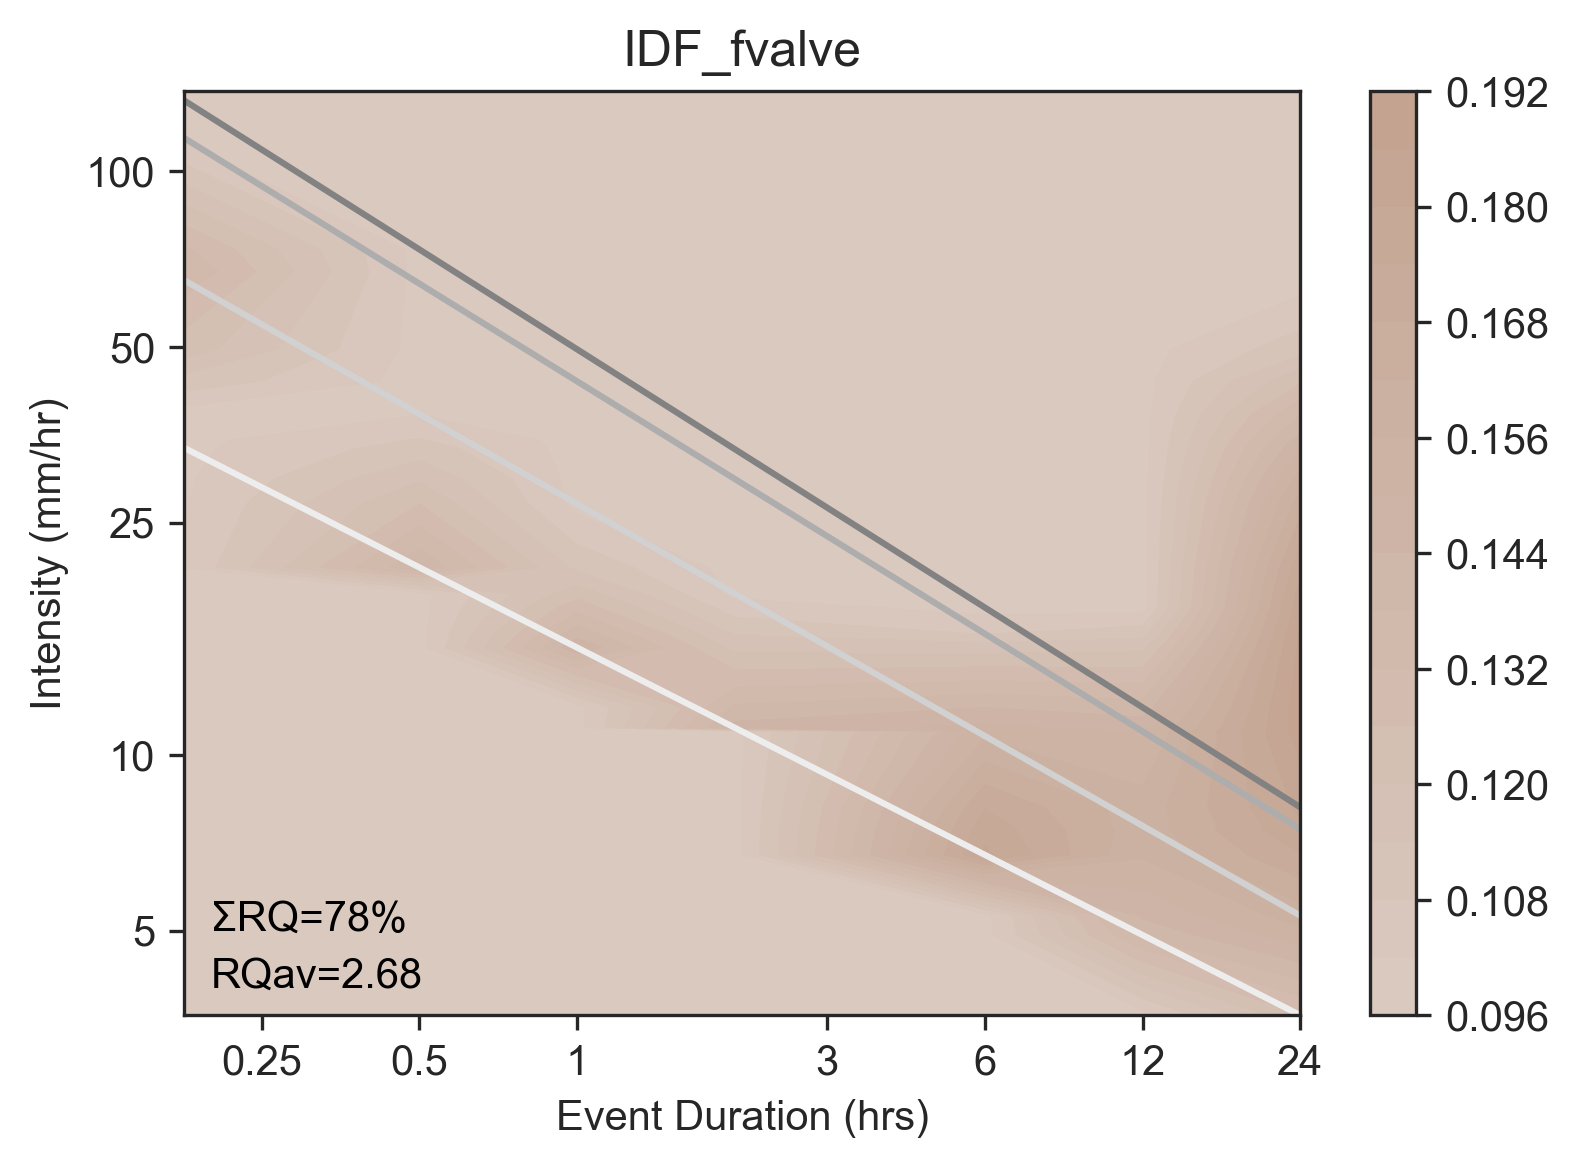

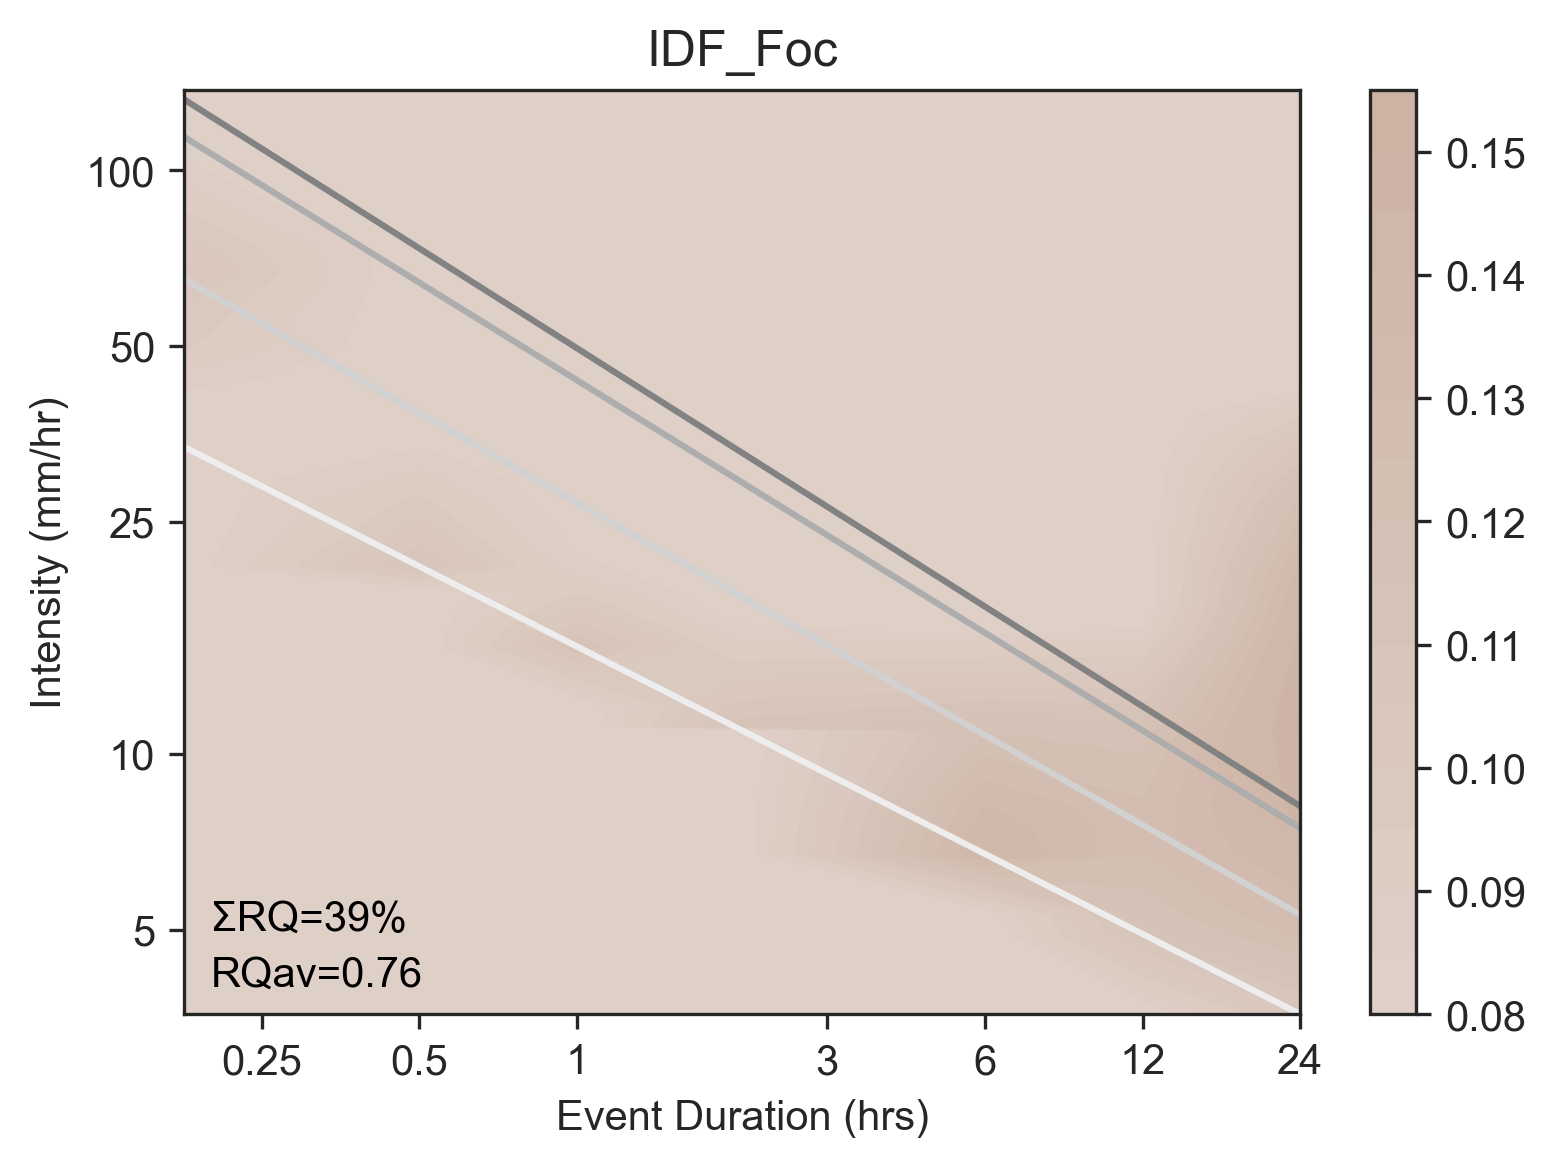

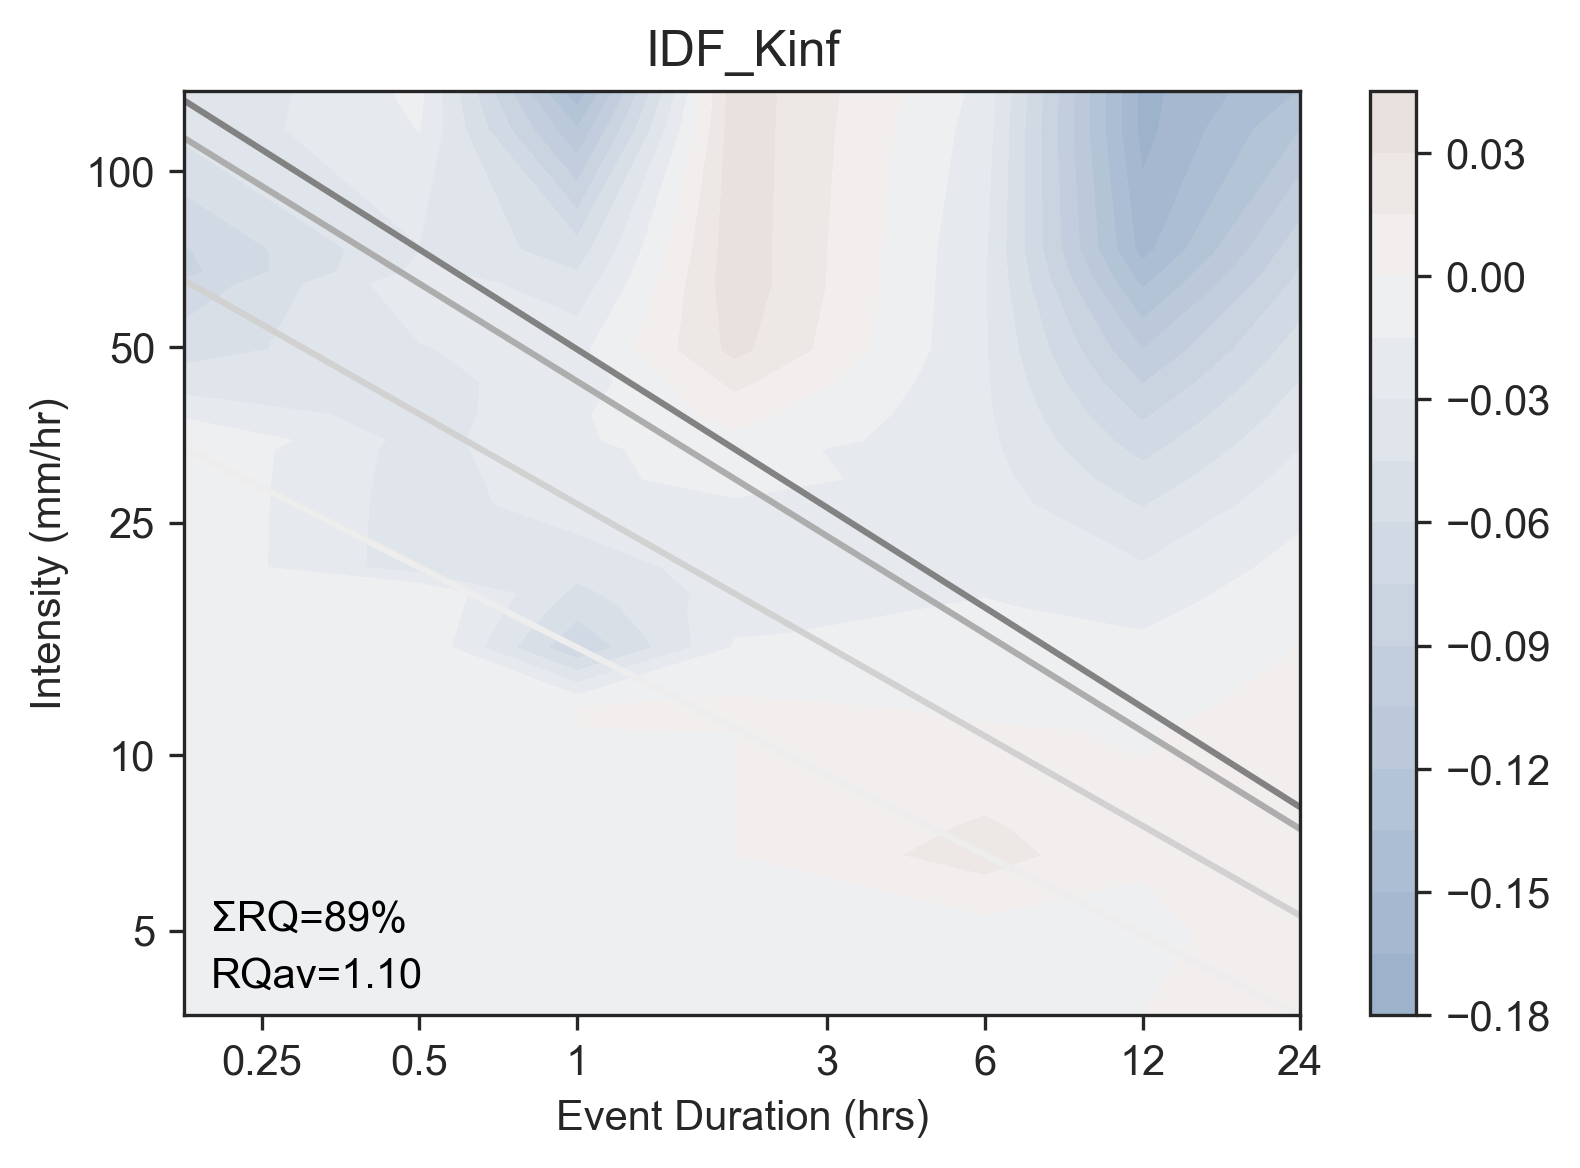

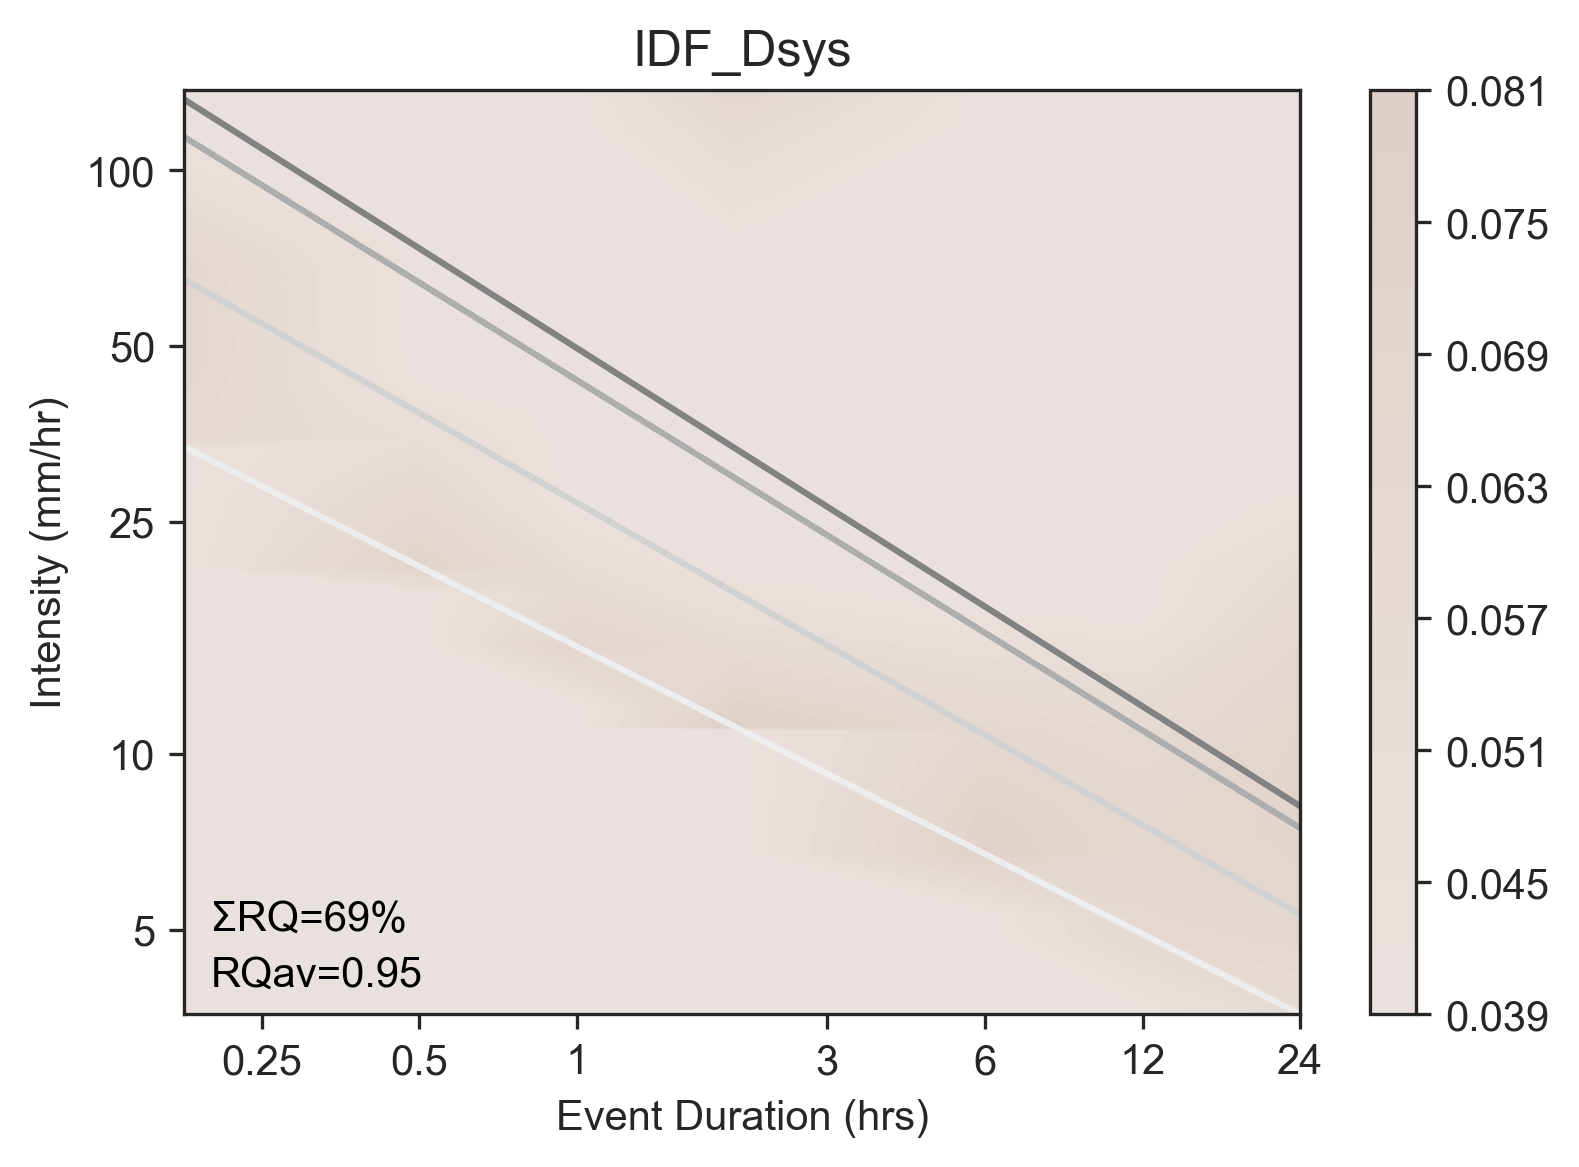

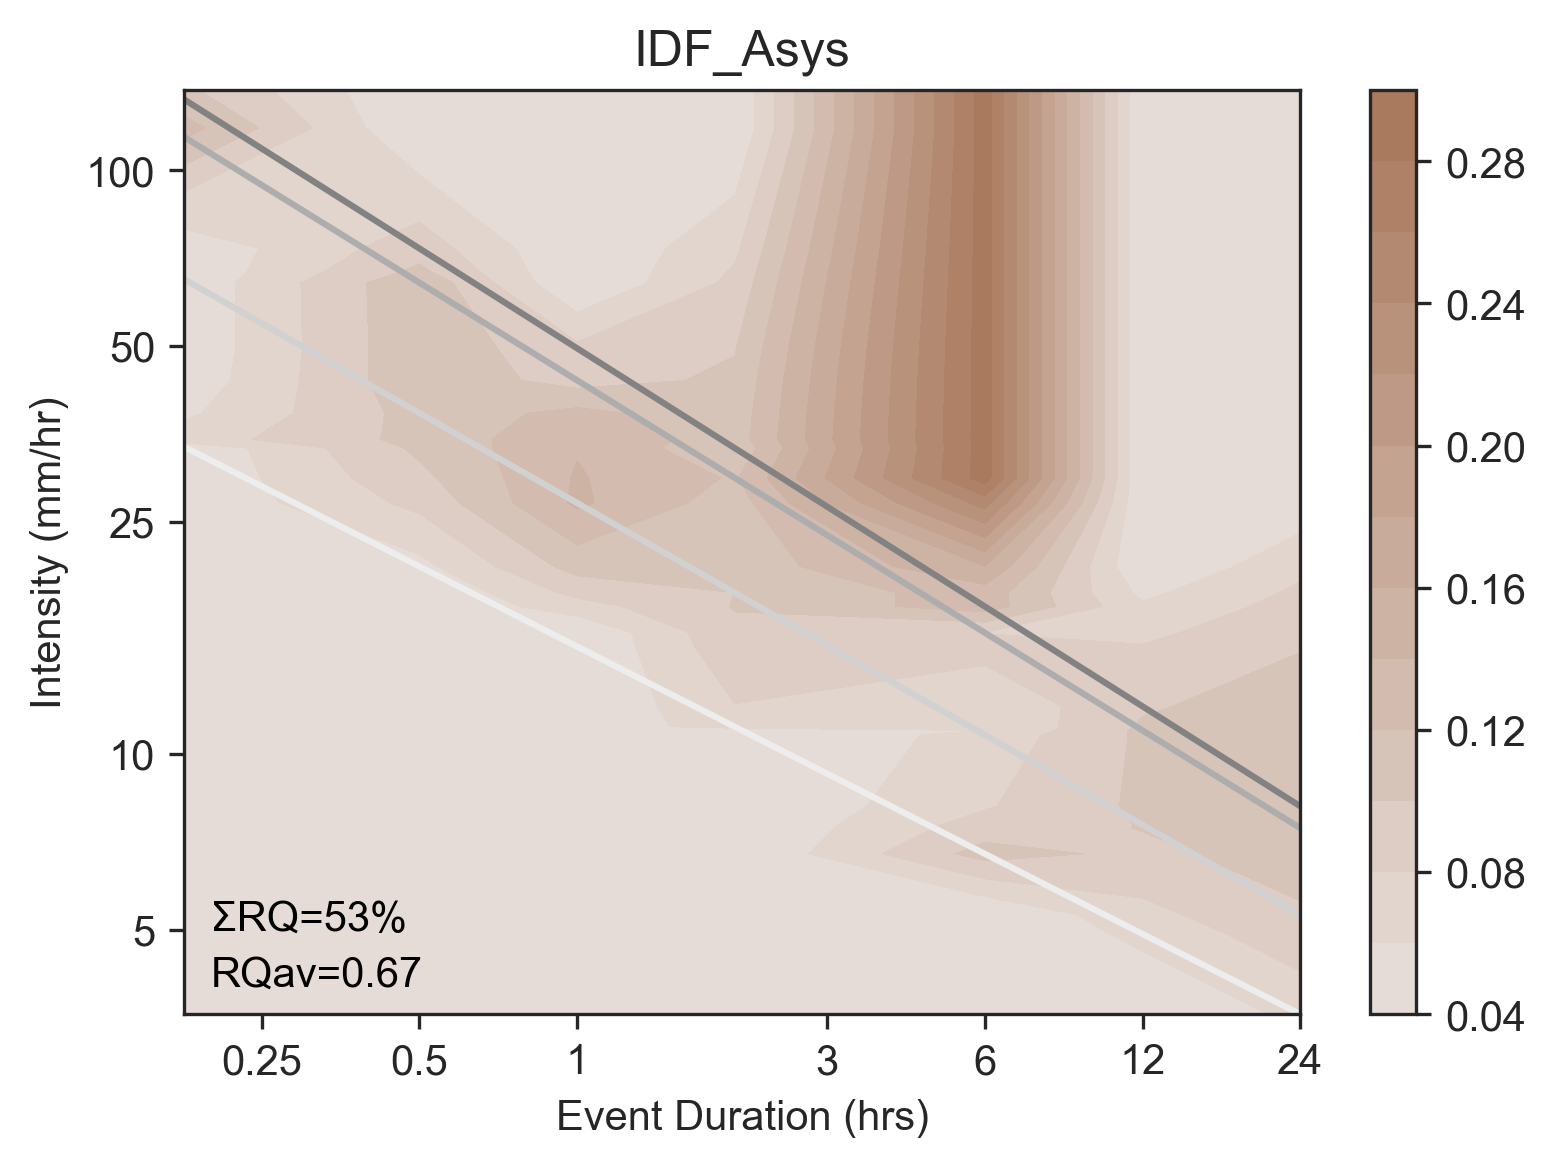

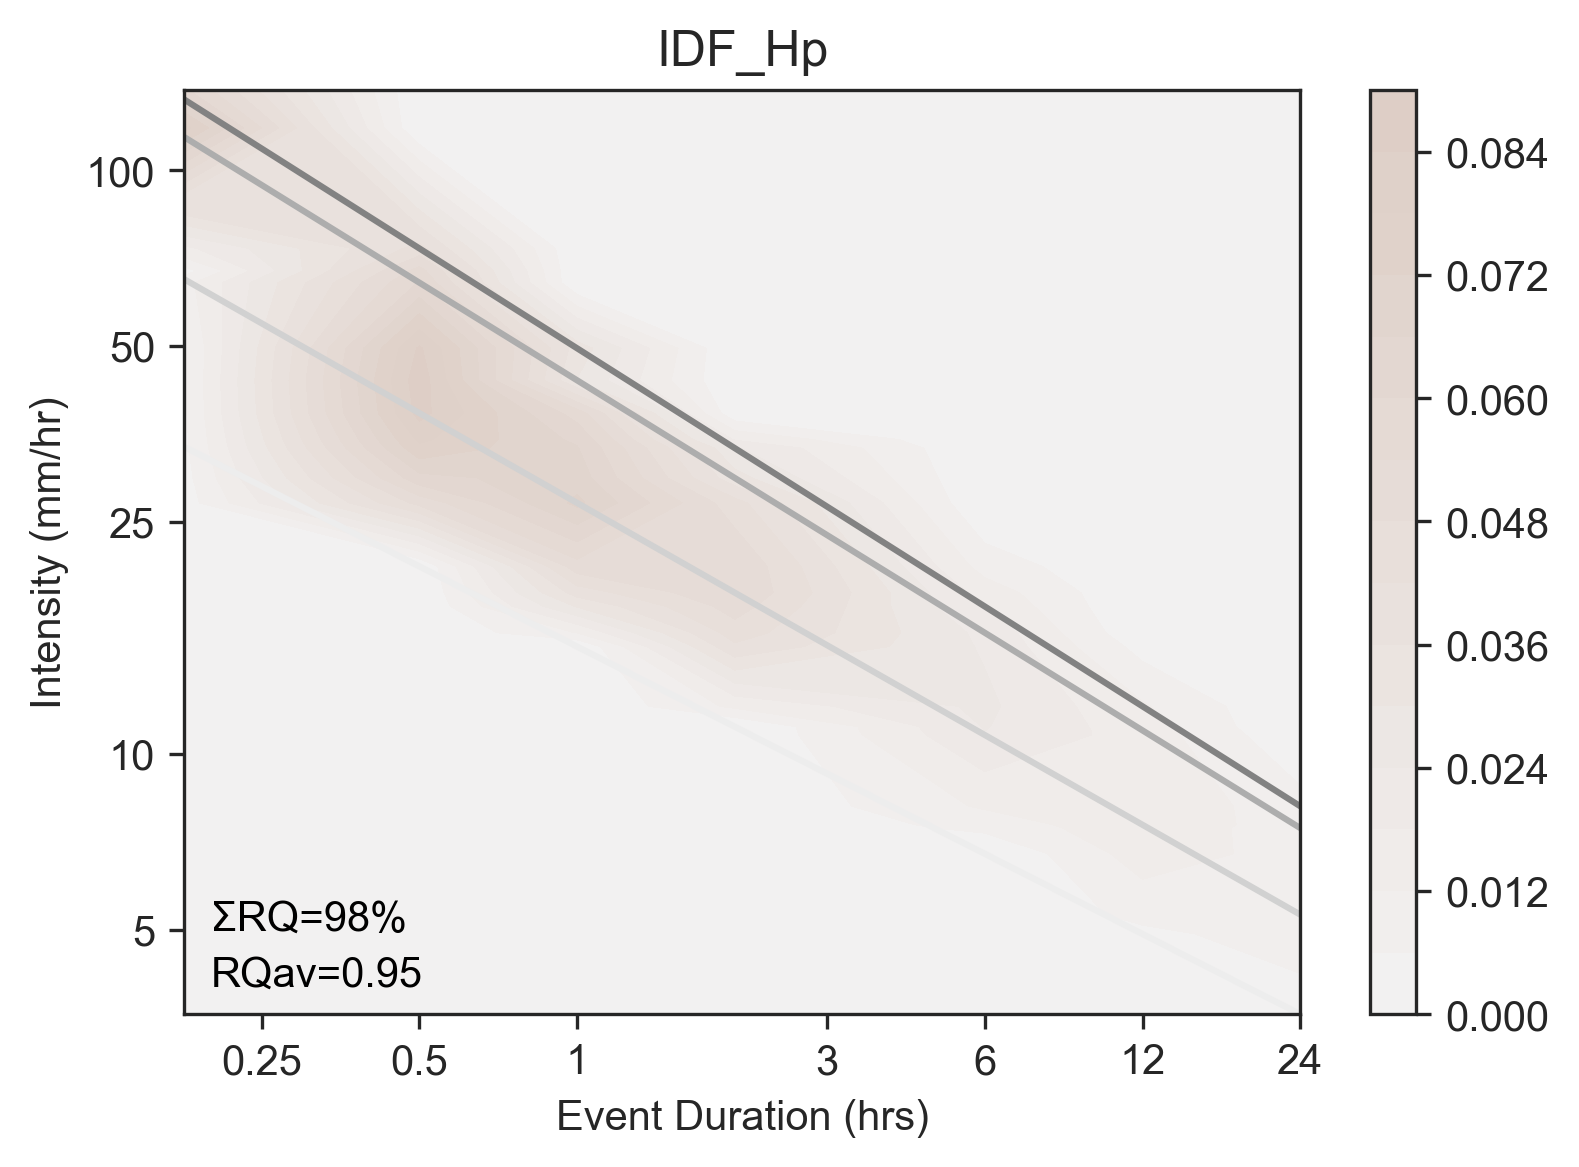

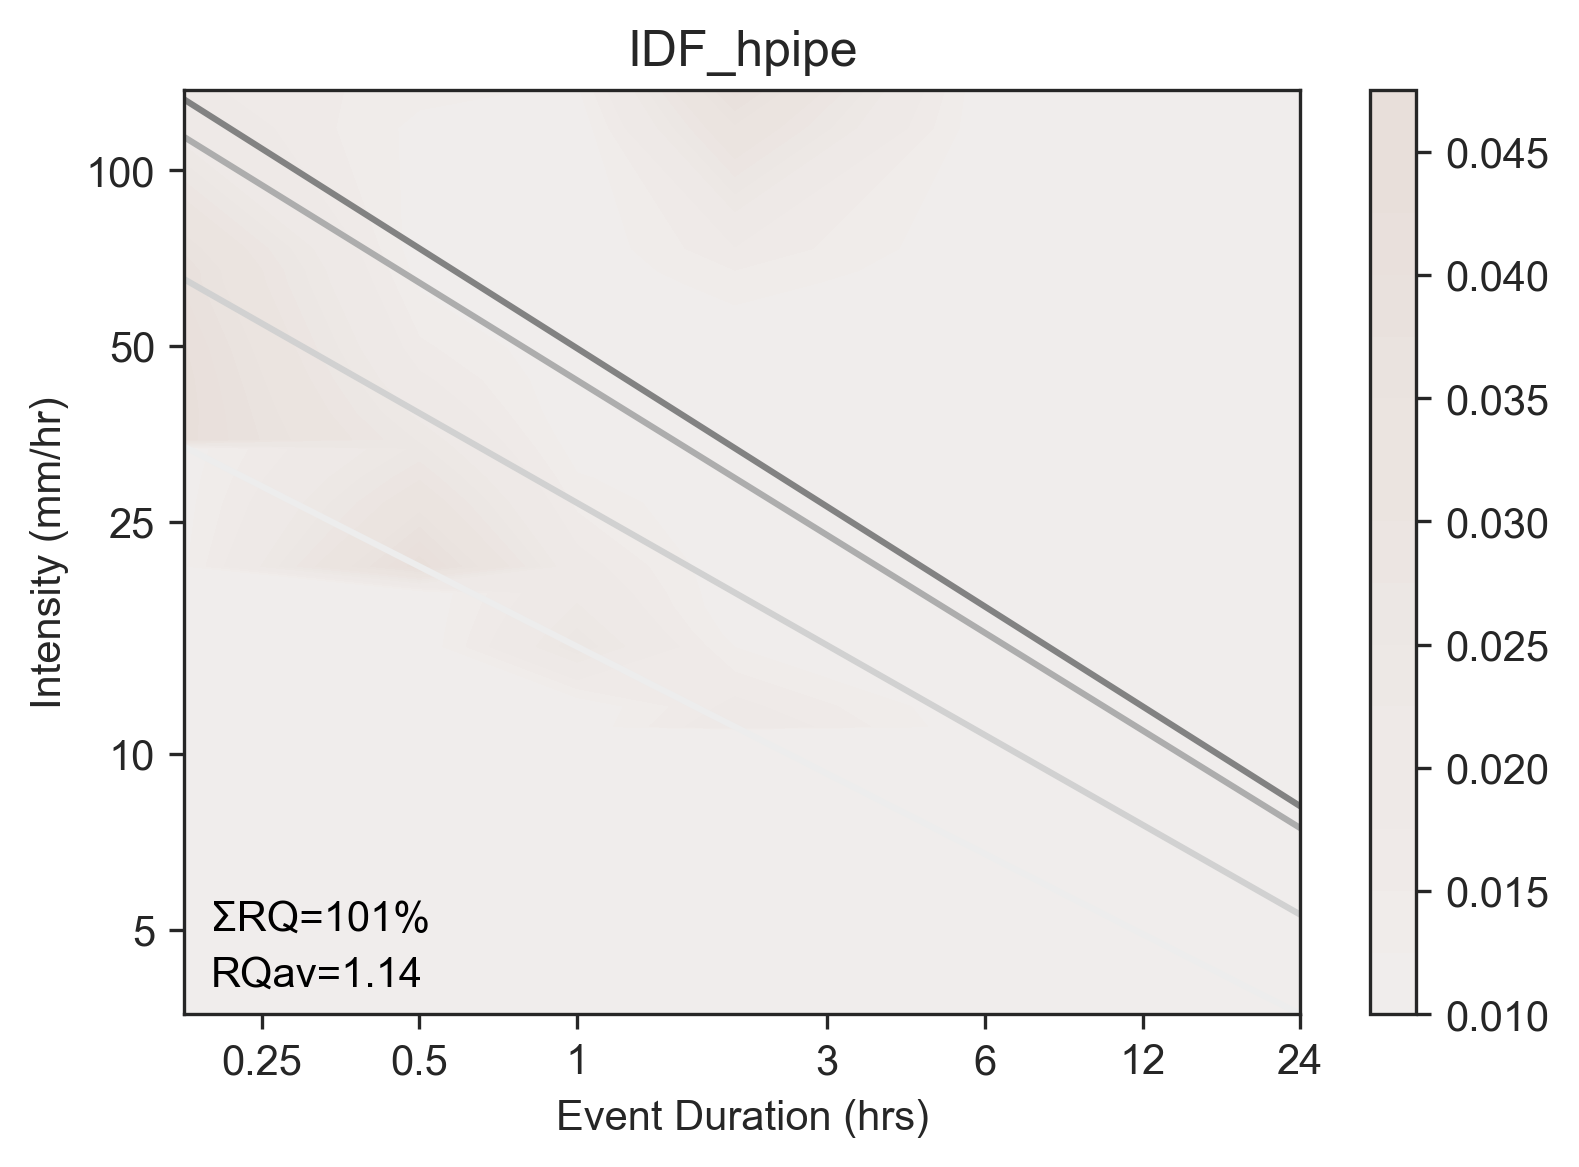

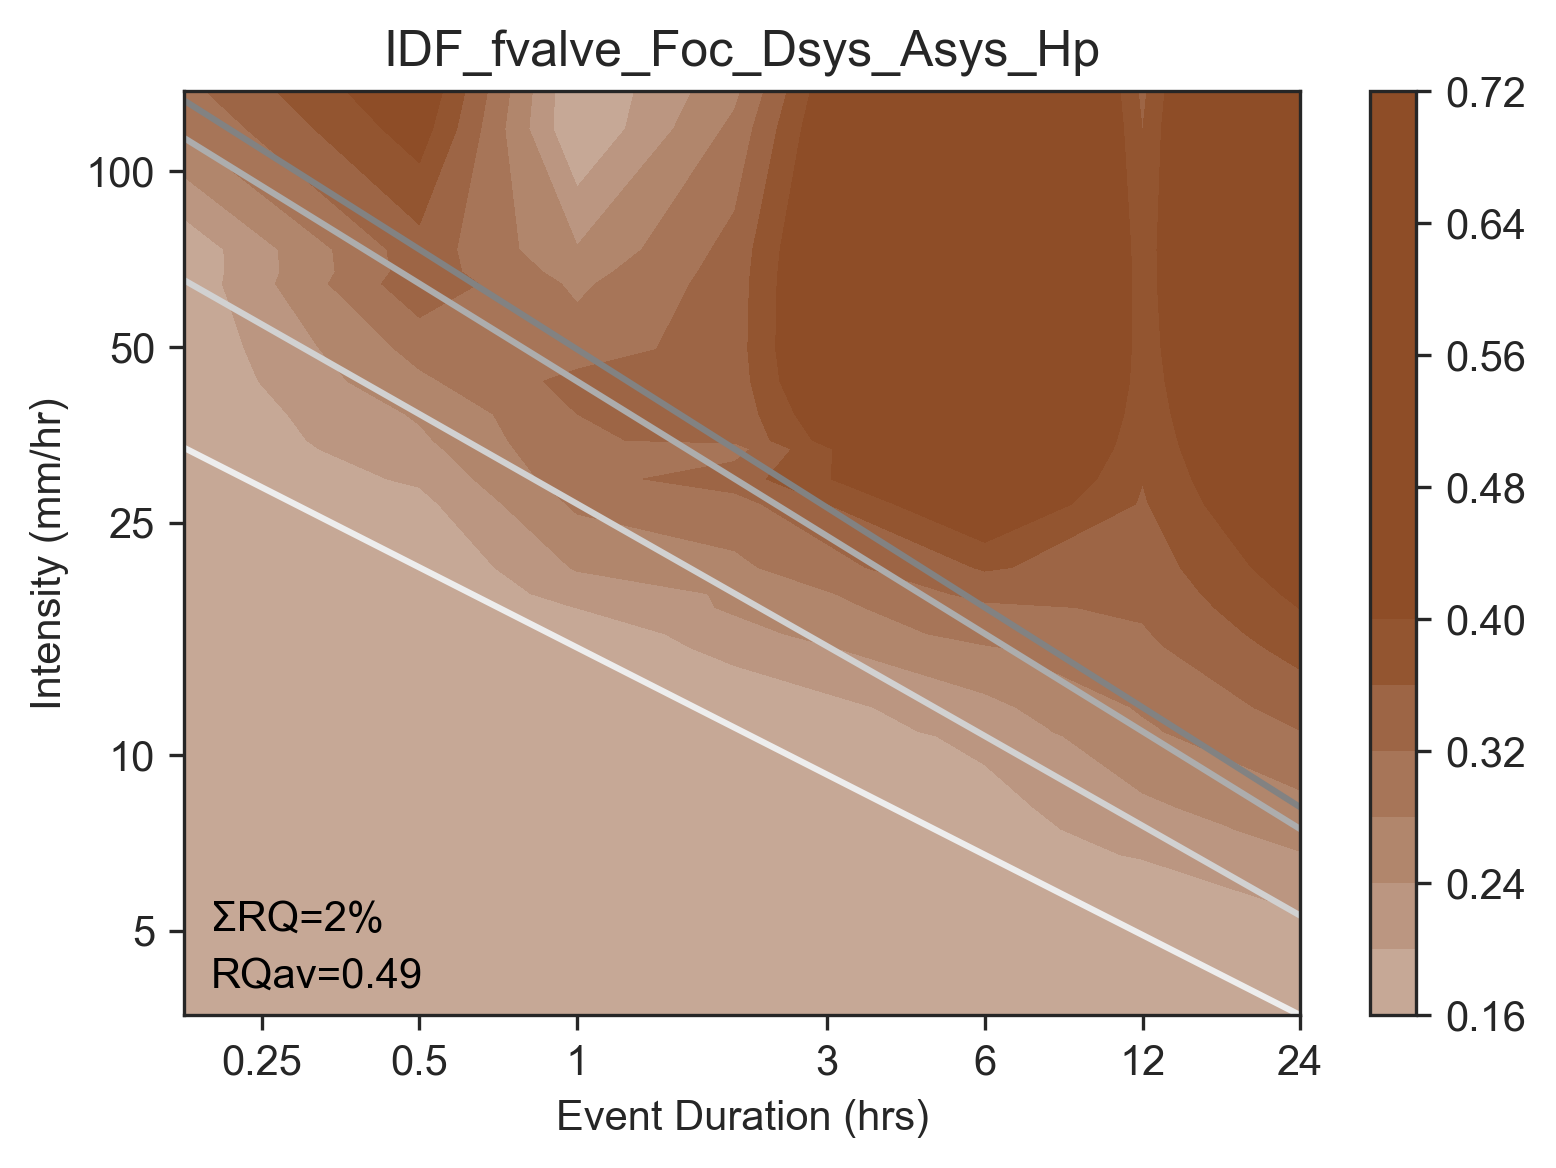

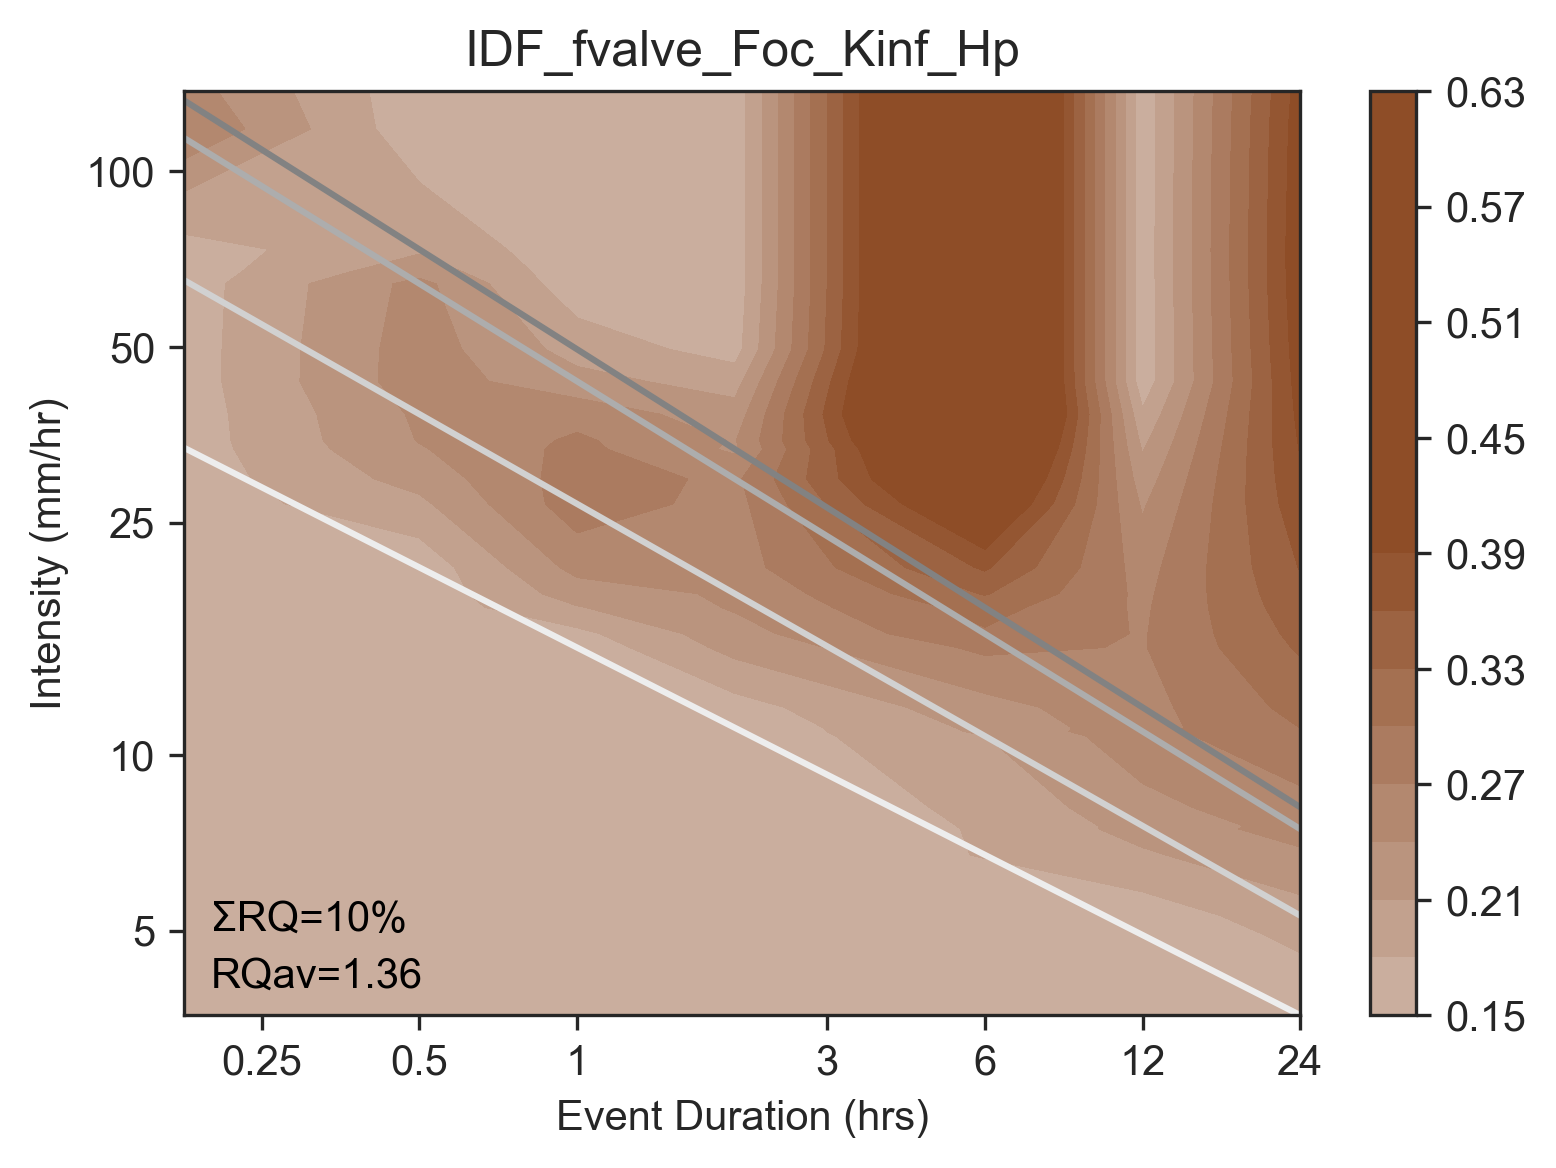

In [169]:
import os
import itertools
import pdb
#Plot system performance on IDF curves. This plots the change from bnase case values. 
#Inputs
inpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDFouts/'
#outpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
#Load data
defname = 'IDF_lowkn.pkl'
#defname = 'IDF_.pkl'
defdata = pd.read_pickle(inpath+defname)
#scenarios = ['fvalve', 'Foc', 'Kinf', 'Dsys', 'Asys', 'Hp']
scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False,'hpipe':False}#
combos = ((1,0,0,0,0,0,0),(0,1,0,0,0,0,0),(0,0,1,0,0,0,0),(0,0,0,1,0,0,0),(0,0,0,0,1,0,0),
          (0,0,0,0,0,1,0),(0,0,0,0,0,0,1),(1,1,0,1,1,1,0),(1,1,1,0,0,1,0))
#combos = ((1,0,0,0,0,0),(0,1,0,0,0,0),(0,0,1,0,0,0),(0,0,0,1,0,0),(0,0,0,0,1,0),(0,0,0,0,0,1),
#          (1,1,0,0,1,1),(1,1,0,0,0,1))
#for scenario in scenarios:
#combos = list(itertools.product([0,1],repeat=7))
#combos = combos[:38]
#combos = ((0,0,0,0,0,0,1),(0,0,1,0,0,0,0))
#combos =((1,1,0,1,1,1,0),)
for combo in combos:
    #pdb.set_trace()
    scenario_dict = {'fvalve': False, 'Foc': False, 'Kinf':False, 'Dsys':False, 'Asys':False, 'Hp':False,'hpipe':False}
    for ind, param in enumerate(scenario_dict):
        #pdb.set_trace()
        scenario_dict[param] = bool(combo[ind])
    filtered = [k for k,v in scenario_dict.items() if v == True]
    testname = 'IDF_lowkn'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_'+'_'.join(filtered)+'.pkl'
    #testname = 'IDF_defaults'
    try:
        pltdata = pd.read_pickle(inpath+testname)
    except FileNotFoundError:
        continue
    #Define the x and y axes
    xticks = [0.25,0.5,1,3, 6,12,24]
    xticks = [np.log10(xticks),xticks]
    yticks = [5,10,25,50,100]
    yticks = [np.log10(yticks),yticks]
    #Define the variables to plot
    pltvars=['pct_stormsewer','LogD','LogI']
    pltvars_delta = pltvars.copy()
    delname = pltvars[0] +'_delta'
    pltvars_delta[0] = delname
    pltdata.loc[:,delname] = defdata.loc[:,pltvars[0]] - pltdata.loc[:,pltvars[0]]
    #pdb.set_trace()
    #pltvars=['RQ_av','LogD','LogI']
    #Determine the average risk quotients, sum as a % of the base-case, av as actual value
    bcRQsum = defdata.RQ_sum.sum()
    RQs = [pltdata.RQ_sum.sum()/bcRQsum,pltdata.RQ_av.mean()]
    #Define other parameters
    #Limit of interpolation - values outside of these limits will be set to these. Use "none" for no limits
    hilim = np.round(2*max(pltdata.loc[:,delname]),decimals=2)
    lolim = np.round(2*min(pltdata.loc[:,delname]),decimals=2)
    interplims = [lolim,hilim]
    #interplims = [0.,3.5]
    vlims = [-0.4,0.4]
    #vlims = [lolim,hilim]#[0.15,3.5]#
    #pdb.set_trace()
    #define the colormap - default is brown-blue
    #cmap = None
    #if lolim<0:
    #    cmap = sns.diverging_palette(250, 30, l=40,s=80,center="light", as_cmap=True)
    #else: 
    #    cmap = sns.light_palette('#8f4e27', as_cmap=True)
    cmap = sns.diverging_palette(250, 30, l=40,s=80,center="light", as_cmap=True)
        #cmap = sns.light_palette("seagreen", as_cmap=True)
    #cmap = sns.cubehelix_palette(start=.75, rot=-.5,light=0.85, as_cmap=True)
    #cmap = sns.cubehelix_palette(n_colors = 7,start=1.40, rot=-0.9,gamma = 0.3, hue = 0.9, dark=0.1, light=.95,as_cmap=True,reverse=True)
    bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) 
    fig,ax = bc.plot_idfs(pltdata,pltvars=pltvars_delta,cmap=cmap,vlims=vlims,interplims=interplims,
                          xticks=xticks,yticks=yticks,figsize=(6,4))
    ax.set_xlabel('Event Duration (hrs)')
    ax.set_ylabel('Intensity (mm/hr)')
    #figname = 'IDF_delta_'+str(scenario)
    figname = 'IDF_'+'_'.join(filtered)
    ax.set_title(figname)
    #Annotate the risk quotients
    ax.annotate('ΣRQ='+f'{RQs[0]:.0%}',xy= (np.log10(0.2),np.log10(5)),color = 'k')
    ax.annotate('RQav='+f'{RQs[1]:.2f}',xy= (np.log10(0.2),np.log10(4)),color = 'k')           
    figpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
    #
    fig.savefig(figpath+figname+'.pdf',format='pdf')
    #fig.savefig()